In [1]:
import datetime

import pandas as pd
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, FloatType
from pyspark.sql import functions as F
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors, VectorUDT

In [2]:
spark = SparkSession.builder.config("spark.driver.memory", "15G").getOrCreate()

In [3]:
spark

# Convert CSV to Parquet

In [4]:
schema = StructType([
    StructField("LCLid",                   StringType(),    False),
    StructField("stdorToU",                StringType(),    False),
    StructField("DateTime",                TimestampType(), False),
    StructField("KWH/hh (per half hour) ", FloatType(),     False),
    StructField("Acorn",                   StringType(),    False),
    StructField("Acorn_grouped",           StringType(),    False),
])

In [64]:
(
    spark
    .read
    .format("csv")
    .option("header", True)
    .schema(schema)
    .load("../../data/raw/low-carbon-london/*.csv")
    .withColumnRenamed("LCLid", "meter_id")
    .withColumnRenamed("stdorToU", "stdortou")
    .withColumnRenamed("DateTime", "dt")
    .withColumnRenamed("KWH/hh (per half hour) ", "kwh")
    .withColumnRenamed("Acorn", "acorn")
    .withColumnRenamed("Acorn_grouped", "acorn_grouped")
    .write
    .format("parquet")
    .save("../../data/processed/low-carbon-london.parquet")
)

In [ ]:
slots = [
    datetime.time(i // 2, i % 2 * 30).strftime("%H:%M")
    for i in range(48)
]

(
    df_ins_norm
    .withColumn("date", F.to_date("dt"))
    .withColumn("time", F.concat_ws(":", F.lpad(F.hour("dt"), 2, "0"), F.lpad(F.minute("dt"), 2, "0")))
    .groupby("meter_id", "date")
    .pivot("time", values=slots)
    .agg(F.first("load_factor"))
    .write
    .format("parquet")
    .save(df_ins_norm_wide_path)
)

# Load Parquet Dataset

In [7]:
df = (
    spark
    .read
    .format("parquet")
    .load("../../data/processed/low-carbon-london.parquet")
)

## Separate in-sample from out-of-sample

In [8]:
pc = 0.95

meters_with_enough_samples = (
    df
    .dropna(subset=["kwh"])
    .withColumn("month", F.month("dt"))
    .groupby("meter_id", "month")
    .agg({"month": "count"})
    .filter(
        (F.col("month") == 1)  & (F.col("count(month)") >= round(31 * 48 * pc)) |
        (F.col("month") == 2)  & (F.col("count(month)") >= round(28 * 48 * pc)) |
        (F.col("month") == 3)  & (F.col("count(month)") >= round(31 * 48 * pc)) |
        (F.col("month") == 4)  & (F.col("count(month)") >= round(30 * 48 * pc)) |
        (F.col("month") == 5)  & (F.col("count(month)") >= round(31 * 48 * pc)) |
        (F.col("month") == 6)  & (F.col("count(month)") >= round(30 * 48 * pc)) |
        (F.col("month") == 7)  & (F.col("count(month)") >= round(31 * 48 * pc)) |
        (F.col("month") == 8)  & (F.col("count(month)") >= round(31 * 48 * pc)) |
        (F.col("month") == 9)  & (F.col("count(month)") >= round(30 * 48 * pc)) |
        (F.col("month") == 10) & (F.col("count(month)") >= round(31 * 48 * pc)) |
        (F.col("month") == 11) & (F.col("count(month)") >= round(30 * 48 * pc)) |
        (F.col("month") == 12) & (F.col("count(month)") >= round(31 * 48 * pc))
    )
    .groupby("meter_id")
    .agg({"month": "count"})
    .filter("count(month) == 12")
    .select("meter_id")
)

In [18]:
meters_with_enough_samples.show()

+---------+
| meter_id|
+---------+
|MAC005232|
|MAC000041|
|MAC005439|
|MAC002980|
|MAC001761|
|MAC005122|
|MAC003083|
|MAC003509|
|MAC004029|
|MAC001430|
|MAC002560|
|MAC005271|
|MAC000925|
|MAC005303|
|MAC000976|
|MAC004358|
|MAC001803|
|MAC004897|
|MAC004532|
|MAC004692|
+---------+
only showing top 20 rows



In [41]:
# total dates per user
n_dates_total = (
    df
    .withColumn("date", F.to_date("dt"))
    .groupby("meter_id")
    .agg(F.countDistinct("date").alias("n_dates_total"))
)

# total dates per user where all consumption is zero
n_dates_zero = (
    df
    .filter(F.col("kwh") == 0)
    .withColumn("date", F.to_date("dt"))
    .groupby("meter_id", "date")
    .agg(F.count("date").alias("count_date"))
    .orderBy("meter_id", "date")

    .filter(F.col("count_date") == 48)
    .groupby("meter_id")
    .agg(F.count("date").alias("n_dates_zero"))
)

# consumers with 10% or more days of zero consumption
(
    n_dates_total
    .join(n_dates_zero, on="meter_id")
    .withColumn("pc_zero", F.col("n_dates_zero") / F.col("n_dates_total"))
    .filter(F.col("pc_zero") >= 0.1)
    .write
    .format("parquet")
    .save("../../data/processed/outliers.parquet")
)

In [29]:
sampletype = (
    df
    .select("meter_id")
    .distinct()
    .join(meters_with_enough_samples.withColumn("insample", F.lit(True)), on="meter_id", how="left")
    .fillna(False, subset=["insample"])
)

In [6]:
# n_slots_required = 365 * 0.95 * 48  # 95% of 1 year

In [7]:
# sampletype = (
#     df
#     .groupby("meter_id")
#     .agg({"kwh": "count"})
#     .withColumn("insample", F.col("count(kwh)") >= n_slots_required)
#     .drop("count(kwh)")
# )

In [26]:
sampletype.groupby("insample").count().show()

+--------+-----+
|insample|count|
+--------+-----+
|    true| 5338|
|   false|  228|
+--------+-----+



## Write in-sample and out-of-sample to local filesystem

In [30]:
(
    df
    .join(sampletype, on="meter_id")
    .filter(F.col("insample") == True)
    .dropna(subset=["kwh"])
    .write
    .format("parquet")
    .save("../../data/processed/insample.parquet")
)

In [10]:
# (
#     df
#     .join(sampletype, on="meter_id")
#     .filter(F.col("insample") == False)
#     .dropna(subset=["kwh"])
#     .write
#     .format("parquet")
#     .save("../../data/processed/outofsample.parquet")
# )

In [3]:
df_ins = spark.read.format("parquet").load("../../data/processed/insample.parquet")
# df_oos = spark.read.format("parquet").load("../../data/processed/outofsample.parquet")

In [5]:
df_ins.filter("meter_id = 'MAC004067'").show()

+---------+--------+-------------------+---+-------+-------------+--------+
| meter_id|stdortou|                 dt|kwh|  acorn|acorn_grouped|insample|
+---------+--------+-------------------+---+-------+-------------+--------+
|MAC004067|     Std|2012-05-18 10:30:00|0.0|ACORN-U|      ACORN-U|    true|
|MAC004067|     Std|2012-05-18 11:00:00|0.0|ACORN-U|      ACORN-U|    true|
|MAC004067|     Std|2012-05-18 11:30:00|0.0|ACORN-U|      ACORN-U|    true|
|MAC004067|     Std|2012-05-18 12:00:00|0.0|ACORN-U|      ACORN-U|    true|
|MAC004067|     Std|2012-05-18 12:30:00|0.0|ACORN-U|      ACORN-U|    true|
|MAC004067|     Std|2012-05-18 13:00:00|0.0|ACORN-U|      ACORN-U|    true|
|MAC004067|     Std|2012-05-18 13:30:00|0.0|ACORN-U|      ACORN-U|    true|
|MAC004067|     Std|2012-05-18 14:00:00|0.0|ACORN-U|      ACORN-U|    true|
|MAC004067|     Std|2012-05-18 14:30:00|0.0|ACORN-U|      ACORN-U|    true|
|MAC004067|     Std|2012-05-18 15:00:00|0.0|ACORN-U|      ACORN-U|    true|
|MAC004067| 

# Apply per-meter MinMax scaling to individual consumers

In [4]:
insample_norm_path = "../../data/processed/insample-norm.parquet"

In [5]:
(
    df_ins
    .dropna(subset=["kwh"])
    .join(df_ins.groupby("meter_id").max("kwh"), on="meter_id")
    .withColumn("load_factor", F.col("kwh") / F.col("max(kwh)"))
    .select("meter_id", "dt", "load_factor")
    .write
    .format("parquet")
    .save(insample_norm_path)
)

In [6]:
df_ins_norm = spark.read.format("parquet").load(insample_norm_path)

# Convert to wide format

In [7]:
slots = [
    datetime.time(i // 2, i % 2 * 30).strftime("%H:%M")
    for i in range(48)
]

In [8]:
df_ins_norm_wide_path = "../../data/processed/insample-norm-wide.parquet"

In [9]:
(
    df_ins_norm
    .withColumn("date", F.to_date("dt"))
    .withColumn("time", F.concat_ws(":", F.lpad(F.hour("dt"), 2, "0"), F.lpad(F.minute("dt"), 2, "0")))
    .groupby("meter_id", "date")
    .pivot("time", values=slots)
    .agg(F.first("load_factor"))
    .write
    .format("parquet")
    .save(df_ins_norm_wide_path)
)

In [10]:
df_ins_norm_wide = spark.read.format("parquet").load(df_ins_norm_wide_path)

# Create feature vector and train KMeans model

In [11]:
sample_idx = [
    "MAC000032",
    "MAC000041",
    "MAC000338",
    "MAC000925",
    "MAC000976",
    "MAC001430",
    "MAC001761",
    "MAC001803",
    "MAC002560",
    "MAC002980",
    "MAC003083",
    "MAC003509",
    "MAC004029",
    "MAC004358",
    "MAC004532",
    "MAC004692",
    "MAC004897",
    "MAC005122",
    "MAC005232",
    "MAC005271",
]

In [3]:
path_feature_vector = "../../data/processed/insample-feature-vector.parquet"

In [12]:
avg_slots = [
    "avg(%s)" % datetime.time(i // 2, i % 2 * 30).strftime("%H:%M")
    for i in range(48)
]

In [13]:
list_to_vector_udf = F.udf(lambda l: Vectors.dense(l), VectorUDT())

In [14]:
df_ins_norm_wide

DataFrame[meter_id: string, date: date, 00:00: double, 00:30: double, 01:00: double, 01:30: double, 02:00: double, 02:30: double, 03:00: double, 03:30: double, 04:00: double, 04:30: double, 05:00: double, 05:30: double, 06:00: double, 06:30: double, 07:00: double, 07:30: double, 08:00: double, 08:30: double, 09:00: double, 09:30: double, 10:00: double, 10:30: double, 11:00: double, 11:30: double, 12:00: double, 12:30: double, 13:00: double, 13:30: double, 14:00: double, 14:30: double, 15:00: double, 15:30: double, 16:00: double, 16:30: double, 17:00: double, 17:30: double, 18:00: double, 18:30: double, 19:00: double, 19:30: double, 20:00: double, 20:30: double, 21:00: double, 21:30: double, 22:00: double, 22:30: double, 23:00: double, 23:30: double]

In [84]:
df_feature_vector = (
    # start with a wide representation of our data
    df_ins_norm_wide
    
    # add daytype and month columns to our dataset for grouping
    .withColumn("daytype", F.when(F.dayofweek("date").isin([1, 7]), "WE").otherwise("BUS"))
    .withColumn("month", F.month("date"))
    
    # calculate the average monthly load curve for each meter and daytype
    .groupby("meter_id", "daytype", "month")
    .mean(*slots)
    
    # transform our slot columns into a single array column
    .select("meter_id", "daytype", "month", F.array(*avg_slots).alias("c"))
    
    # sort everything so that when we concat arrays they are
    # in the correct order
    .orderBy("meter_id", "daytype", "month")
    
    # concat our mean load curves into a single array
    .groupby("meter_id")
    .agg(F.flatten(F.collect_list("c")).alias("features"))
    
    # cast our features column into a DenseVector type
    .select("meter_id", list_to_vector_udf("features").alias("features"))

    # remove these guys with not enough records (TODO: do in sampling step)
    .filter("meter_id not in ('MAC004067')")
#     .select("meter_id", F.size("features").alias("lenfeat"))
#     .show()
)

In [21]:
df_feature_vector.select(F.size("features").alias("lenfeat")).distinct().show()

+-------+
|lenfeat|
+-------+
|   1152|
+-------+



In [ ]:
# +--------------+
# |size(features)|
# +--------------+
# |          1056|
# |           912|
# |          1152|
# +--------------+

In [25]:
df_feature_vector.show()

+---------+--------------------+
| meter_id|            features|
+---------+--------------------+
|MAC000032|[0.53495510360781...|
|MAC000041|[0.15674432925709...|
|MAC000338|[0.06985207884214...|
|MAC000925|[0.06952979936340...|
|MAC000976|[0.03878805744912...|
|MAC001430|[0.09760969092946...|
|MAC001761|[0.09663108803997...|
|MAC001803|[0.01054270570701...|
|MAC002560|[0.08773383626408...|
|MAC002980|[0.12055694325014...|
|MAC003083|[0.02694927111204...|
|MAC003509|[0.03287211738539...|
|MAC004029|[0.12783493416433...|
|MAC004358|[0.04828897139205...|
|MAC004532|[0.0761121977589,...|
|MAC004692|[0.07735540075419...|
|MAC004897|[0.64797426084074...|
|MAC005122|[0.13781342022964...|
|MAC005232|[0.01592042640346...|
|MAC005271|[0.03910530191387...|
+---------+--------------------+
only showing top 20 rows



In [30]:
df_feature_vector.select("features").limit(10).show()

+--------------------+
|            features|
+--------------------+
|[0.53495510360781...|
|[0.15674432925709...|
|[0.06985207884214...|
|[0.06952979936340...|
|[0.03878805744912...|
|[0.09760969092946...|
|[0.09663108803997...|
|[0.01054270570701...|
|[0.08773383626408...|
|[0.12055694325014...|
+--------------------+



In [33]:
X_train = df_feature_vector.toPandas()

In [53]:
X_train = X_train.features.apply(lambda x: x.toArray().tolist()).apply(pd.Series).assign(meter_id=X_train.meter_id)

In [82]:
X_train[X_train[[0, "meter_id"]][0].isna()]

,0,1,2,3,4,5,6,7,8,9,...,1143,1144,1145,1146,1147,1148,1149,1150,1151,meter_id
3823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAC004067


In [83]:
X_train[X_train.meter_id == "MAC004067"] # this guy isn't getting picked up!

,0,1,2,3,4,5,6,7,8,9,...,1143,1144,1145,1146,1147,1148,1149,1150,1151,meter_id
3823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAC004067


In [85]:
kmeans = KMeans(k=9, featuresCol="features")
kmeans.setSeed(1)

KMeans_b16ce037181e

In [86]:
model = kmeans.fit(df_feature_vector)

In [88]:
import numpy as np

centers = np.array(model.clusterCenters()); centers.shape

(9, 1152)

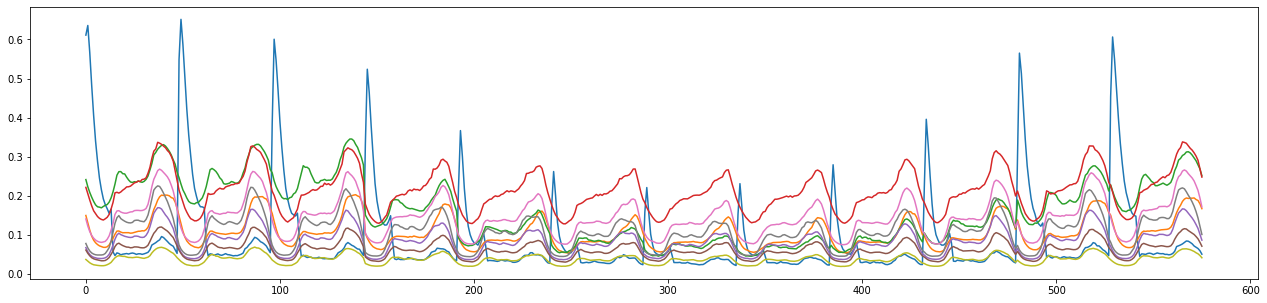

In [90]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(22, 5))

for i in range(centers.shape[0]):
    ax.plot(centers[i][:12 * 48], label=i)

plt.show()

In [ ]:
# if you just wanna check shape, consider a distance metric that cancels out height differences